## Part 11: export data for a web map
michael babb  
2025 10 03

In [1]:
# standard
import os

In [2]:
# external
import geopandas as gpd
import numpy as np
import pandas as pd

In [ ]:
# custom
import run_constants as rc
from geo_data_io.fc_df_spatial import  (write_gdf, keep_largest_geometry,
                    check_MultiLineStrings,
                    inner_ring_buffer)
from geo_data_io.fileio import write_json

# load the city sectors

In [4]:
fpn = os.path.join(rc.OUTPUT_FILE_PATH, rc.S02_CITY_SECTORS_OUT_FILE_NAME)

In [5]:
gdf = gpd.read_file(filename = fpn)

In [6]:
gdf.shape

(16, 3)

In [7]:
gdf.head()

,city_sector,hull_type,geometry
0,NW,convex,"POLYGON ((-122.35768 47.65214, -122.35784 47.6..."
1,NW,concave,"POLYGON ((-122.40637 47.67378, -122.40638 47.6..."
2,N,convex,"POLYGON ((-122.33299 47.61852, -122.33427 47.6..."
3,N,concave,"POLYGON ((-122.35769 47.64955, -122.35769 47.6..."
4,NE,convex,"POLYGON ((-122.3046 47.64749, -122.31007 47.64..."


#  create non-overlapping polygons

In [8]:
# keep only the concave bulls
p_gdf = gdf.loc[gdf['hull_type'] == 'concave', :]

In [9]:
# reproject to wgs 84 utm zone 10
p_gdf = p_gdf.to_crs(epsg = 32610)

<Axes: >

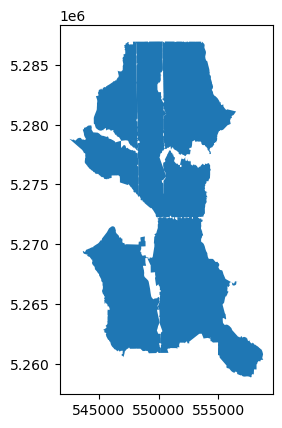

In [10]:
p_gdf.plot()

In [11]:
p_gdf.head()

,city_sector,hull_type,geometry
1,NW,concave,"POLYGON ((544560.158 5280213.434, 544559.88 52..."
3,N,concave,"POLYGON ((548236.706 5277549.869, 548236.48 52..."
5,NE,concave,"POLYGON ((550433.919 5278501.622, 550442.898 5..."
7,CNTR,concave,"POLYGON ((548285.033 5274027.51, 548284.855 52..."
9,E,concave,"POLYGON ((550377.214 5276766.109, 550410.608 5..."


In [12]:
# we first need to reproject
# and then: intersect the data so that it's nice and clean. So clean. 

In [13]:
# here is what needs to be intersected and clipped
# N and CNTR and E and CNTR
g_names = ['N', 'CNTR', 'E']
geom_dict = {}
for gn in g_names:
    geom_dict[gn] = p_gdf.loc[p_gdf['city_sector'] == gn, 'geometry'].iloc[0]

In [14]:
# time to do an intersection!
# north / center geometry
nc_geom = geom_dict['N'].intersection(geom_dict['CNTR'])
# east / center geometry
ec_geom = geom_dict['E'].intersection(geom_dict['CNTR'])

# the isolated center geometry
c_geom = geom_dict['CNTR'].difference(geom_dict['N'])
c_geom = c_geom.difference(geom_dict['E'])

# we also need only the north and east geometry. Compute the difference
# north / center geometry
nc_diff_geom = geom_dict['N'].difference(geom_dict['CNTR'])
# east / center geometry
ec_diff_geom = geom_dict['E'].difference(geom_dict['CNTR'])


In [15]:
# gather and create a geodataframe
geom_list = [c_geom, nc_geom, ec_geom, nc_diff_geom, ec_diff_geom]
data_list = ['CNTR', 'NC', 'EC', 'N', 'E']
mod_gdf = gpd.GeoDataFrame(data = {'city_sector':data_list},
                           geometry = geom_list, crs = 32610)

In [16]:
# clean up the geometries
mod_gdf = keep_largest_geometry(gdf = mod_gdf, group_col_names=['city_sector'])

In [17]:
mod_gdf.head()

,city_sector,geometry
0,CNTR,"POLYGON ((548207.446 5274110.047, 548205.081 5..."
1,NC,"POLYGON ((548236.48 5277575.735, 548237.788 52..."
2,EC,"POLYGON ((553990.355 5274053.615, 554005.492 5..."
3,N,"POLYGON ((548236.052 5277648.077, 548281.925 5..."
4,E,"POLYGON ((550410.608 5276841.828, 550415.26 52..."


In [18]:
# add them to the other geodataframe with the good geometry:
p_gdf.head()

,city_sector,hull_type,geometry
1,NW,concave,"POLYGON ((544560.158 5280213.434, 544559.88 52..."
3,N,concave,"POLYGON ((548236.706 5277549.869, 548236.48 52..."
5,NE,concave,"POLYGON ((550433.919 5278501.622, 550442.898 5..."
7,CNTR,concave,"POLYGON ((548285.033 5274027.51, 548284.855 52..."
9,E,concave,"POLYGON ((550377.214 5276766.109, 550410.608 5..."


In [19]:
mod_gdf['hull_type'] = 'concave'

In [20]:
col_names = p_gdf.columns.tolist()
mod_gdf = mod_gdf[col_names]

In [21]:
# drop existing geometries in the p_gdf GDF
p_gdf = p_gdf.loc[-p_gdf['city_sector'].isin(mod_gdf['city_sector']), :]

In [22]:
# stack by concat
p_gdf = pd.concat(objs = [p_gdf, mod_gdf], axis = 0)

In [23]:
p_gdf = p_gdf.to_crs(epsg=4326)

In [24]:
write_gdf(gdf = p_gdf, output_file_path=rc.OUTPUT_FILE_PATH, output_file_name=rc.S11_NON_OVERLAPPING_CITY_SECTORS_FILE_NAME)

# create inner ring buffers
The inner ring buffers of the different city sectors aren't used in any analysis.
They are used in the webmap to help orient the reader for the different sectors.
In doing so, it will make the within-sector and cross-sector added streets make
more sense.

In [25]:
# convert to WGS 84 UTM Zone 10 N, for creating the inner-ring buffers
p_gdf = p_gdf.to_crs(epsg = 32610)

In [26]:
cc_gdf = gdf.loc[gdf['hull_type'] == 'concave', ]

In [27]:
cc_gdf = cc_gdf.to_crs(epsg = 32610)

In [28]:
# let's do some fun inner ring buffering - the non-overlapping data
output_gdf, output_line_gdf = inner_ring_buffer(gdf = p_gdf,
                                                 dist_start=10,
                                                 dist_end=100, buff_dist=10)

# project to WGS 84
output_gdf = output_gdf.to_crs(epsg = 4326)

# project to WGS 84
output_line_gdf = output_line_gdf.to_crs(epsg = 4326)

# save this to disk
write_gdf(gdf = output_gdf, output_file_path=rc.OUTPUT_FILE_PATH,
          output_file_name=rc.S11_NON_OVERLAPPING_CITY_SECTORS_POLY_INNER_RING_BUFFER_FILE_NAME)
write_gdf(gdf = output_line_gdf, output_file_path=rc.OUTPUT_FILE_PATH,
          output_file_name=rc.S11_NON_OVERLAPPING_CITY_SECTORS_LINE_INNER_RING_BUFFER_FILE_NAME)

Processing row: 1
Processing row: 5
Processing row: 11
Processing row: 13
Processing row: 15
Processing row: 0
Processing row: 1
Processing row: 2
Processing row: 3
Processing row: 4


In [29]:
# let's do some fun inner ring buffering - the full set of geometry
output_gdf, output_line_gdf = inner_ring_buffer(gdf = cc_gdf,
                                                 dist_start=10,
                                                 dist_end=100, buff_dist=10)

# project to WGS 84
output_gdf = output_gdf.to_crs(epsg = 4326)

# project to WGS 84
output_line_gdf = output_line_gdf.to_crs(epsg = 4326)

# save this to disk
write_gdf(gdf = output_gdf, output_file_path=rc.OUTPUT_FILE_PATH,
          output_file_name=rc.S11_OVERLAPPING_CITY_SECTORS_POLY_INNER_RING_BUFFER_FILE_NAME)
write_gdf(gdf = output_line_gdf, output_file_path=rc.OUTPUT_FILE_PATH,
          output_file_name=rc.S11_OVERLAPPING_CITY_SECTORS_LINE_INNER_RING_BUFFER_FILE_NAME)

Processing row: 1
Processing row: 3
Processing row: 5
Processing row: 7
Processing row: 9
Processing row: 11
Processing row: 13
Processing row: 15


In [30]:
# save the output_line_gdf as a geojson for use in a webmap.
# we'll filter different distances in the webmap to get the visual appeal just 
# right. 

In [31]:
temp_output_gdf = output_line_gdf.copy()
temp_output_gdf.head()

,city_sector,hull_type,distance,line_index,geometry
0,NW,concave,10,0,"LINESTRING (-122.40638 47.67405, -122.40638 47..."
1,NW,concave,10,1,"LINESTRING (-122.39602 47.6677, -122.39592 47...."
2,NW,concave,20,0,"LINESTRING (-122.39603 47.6677, -122.39603 47...."
3,NW,concave,20,1,"LINESTRING (-122.39605 47.6681, -122.39604 47...."
4,NW,concave,30,0,"LINESTRING (-122.39609 47.66795, -122.3961 47...."


In [32]:
temp_output_gdf.columns = ['cp', 'hull_type', 'dist', 'li', 'geometry']
temp_output_gdf['cp'] = temp_output_gdf['cp'].str.replace('CNTR', 'C')
cs_json = temp_output_gdf.to_json(drop_id=True, to_wgs84=True)


In [33]:
# let's save this to a geojson
write_json(json_data=cs_json, output_file_path='../maps', output_file_name=rc.S11_CITY_SECTOR_LINES_JSON_FILE_NAME,
           var_name = None)

city_sector_lines


# export street data for use in a web map

In [34]:
fpn = os.path.join(rc.OUTPUT_FILE_PATH, rc.S05_MISSING_IN_FILE_NAME)

In [35]:
gdf = gpd.read_file(filename = fpn)

In [36]:
# dissolve - this also aggregates
col_names = ['ord_stname_type_group','snd_group', 'street_status', 'group_id', 'dist_miles', 'geometry']
diss_gdf = gdf[col_names].dissolve(by = col_names[:-2],
                     aggfunc =  ['sum'], as_index = False)

In [37]:
# set column names
col_names = ['ord_stname_type_group','snd_group', 'street_status', 'group_id', 'geometry', 'dist_miles']
diss_gdf.columns = col_names

In [38]:
# add a column to count the number of records - this will be summed later
diss_gdf['n_segments'] = 1
col_names = ['osntg','sndg', 'ss', 'gi', 'geometry', 'dm', 'ns']
diss_gdf.columns = col_names

In [39]:
# let's try dropping some columns
drop_col_names = ['sndg', 'gi']
diss_gdf = diss_gdf.drop(labels=drop_col_names, axis = 1)

In [40]:
# perform another dissolve in order to get the righ count of segments
# this is necessary because we want continuous segments to be counted as one
diss_gdf.columns
col_names = ['osntg', 'ss', 'dm', 'ns']
diss_gdf = diss_gdf.dissolve(by = col_names[:2], aggfunc =  ['sum'], as_index = False)
diss_gdf.head()

,osntg,ss,geometry,"(dm, sum)","(ns, sum)"
0,100TH PL NW,0,"MULTILINESTRING ((-122.36206 47.7035, -122.363...",0.201049,1
1,100TH PL SW,0,"LINESTRING (-122.3403 47.51334, -122.34036 47....",0.035254,1
2,100TH ST NW_N_NE,1,"MULTILINESTRING ((-122.38757 47.70155, -122.38...",4.535595,9
3,100TH ST NW_N_NE,2,"MULTILINESTRING ((-122.38387 47.70155, -122.38...",0.653439,7
4,100TH ST NW_N_NE,3,"LINESTRING (-122.33512 47.70142, -122.32852 47...",0.307315,1


In [41]:
# rename 
diss_gdf.columns = ['osntg', 'ss', 'geometry', 'dm', 'ns']
diss_gdf.shape
diss_gdf.head()

,osntg,ss,geometry,dm,ns
0,100TH PL NW,0,"MULTILINESTRING ((-122.36206 47.7035, -122.363...",0.201049,1
1,100TH PL SW,0,"LINESTRING (-122.3403 47.51334, -122.34036 47....",0.035254,1
2,100TH ST NW_N_NE,1,"MULTILINESTRING ((-122.38757 47.70155, -122.38...",4.535595,9
3,100TH ST NW_N_NE,2,"MULTILINESTRING ((-122.38387 47.70155, -122.38...",0.653439,7
4,100TH ST NW_N_NE,3,"LINESTRING (-122.33512 47.70142, -122.32852 47...",0.307315,1


In [42]:
# format the osntg output
def format_osntg(sn):
    if '_' in sn:
        pos = sn.rfind(' ') 
        osn = sn[:pos]
        #ost = sn[pos + 1:].replace('_', '] [')
        #outcome = osn + ' : [' + ost + ']'
        ost = sn[pos + 1:].replace('_', ' | ')
        outcome = osn + ': ' + ost

    else:
        outcome = sn
    return outcome


In [43]:
diss_gdf['osntg'] = diss_gdf['osntg'].map(format_osntg)
diss_gdf.head()

,osntg,ss,geometry,dm,ns
0,100TH PL NW,0,"MULTILINESTRING ((-122.36206 47.7035, -122.363...",0.201049,1
1,100TH PL SW,0,"LINESTRING (-122.3403 47.51334, -122.34036 47....",0.035254,1
2,100TH ST: NW | N | NE,1,"MULTILINESTRING ((-122.38757 47.70155, -122.38...",4.535595,9
3,100TH ST: NW | N | NE,2,"MULTILINESTRING ((-122.38387 47.70155, -122.38...",0.653439,7
4,100TH ST: NW | N | NE,3,"LINESTRING (-122.33512 47.70142, -122.32852 47...",0.307315,1


In [44]:
# see if we can collapse MultiLineStrings to LineStrings
diss_gdf['geometry'].geom_type.value_counts()


MultiLineString    1850
LineString          968
Name: count, dtype: int64

In [45]:
diss_gdf['geometry'] = diss_gdf['geometry'].map(check_MultiLineStrings)
diss_gdf['geometry'].geom_type.value_counts()

LineString         1501
MultiLineString    1317
Name: count, dtype: int64

In [46]:
# finally, rename the CNTR streets to just C
diss_gdf['osntg'] = diss_gdf['osntg'].str.replace('CNTR', 'C')
out_data = diss_gdf.to_json(drop_id=True, to_wgs84=True)
output_file_name = rc.S11_STREETS_JSON_FILE_NAME
write_json(json_data=out_data, output_file_path ='../maps',
               output_file_name = output_file_name, var_name = 'all_streets_diss')


all_streets_diss
